In [151]:
import qutip as qt
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm

print("CUDA AVALIABLE:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("DEVICE:", torch.cuda.get_device_name(torch.cuda.current_device()))
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
device = "cpu"
print(f"Using {device} device")

# Custom Imports
from data_gen import read_data, dset_size


CUDA AVALIABLE: True
DEVICE: NVIDIA RTX A4500
Using cpu device


## Load Data

In [4]:
file = "data.hdf5"
complex_type = torch.complex64
states, H = read_data(file, dim=2, label="train", i_start=0, i_end=1000)

In [5]:
d = torch.tensor(H[0, 0], dtype=complex_type).to(device)
d, d.shape

(tensor([[-0.8918+0.j,  0.0000+0.j],
         [ 0.0000+0.j, -0.7244+0.j]], device='cuda:0'),
 torch.Size([2, 2]))

# Try a Model with Complex Data

In [70]:
class Net(nn.Module):
    def __init__(self):
      super(Net, self).__init__()
      self.flatten = nn.Flatten(start_dim=0, end_dim=-1)
      self.dense1= nn.Sequential(
        nn.Linear(4, 2, dtype=complex_type),
        nn.Sigmoid()
      )
      self.dense2 = nn.Sequential(
        nn.Linear(2, 1, dtype=complex_type),
        nn.Sigmoid()
      )

    # x represents our data
    def forward(self, x):

      x = self.flatten(x)
      print(x)
      x = self.dense1(x)
      x = self.dense2(x)

      return x

model = Net().to(device)
print(model)

NameError: name 'complex_type' is not defined

In [7]:
model(d)

tensor([-0.8918+0.j,  0.0000+0.j,  0.0000+0.j, -0.7244+0.j], device='cuda:0')


tensor([0.6411+0.1663j], device='cuda:0', grad_fn=<SigmoidBackward0>)

# Make a PyTorch Data Loader for Data

In [120]:
class timeStepData(Dataset):
    def __init__(self, hfile, dim, label, complex_type=torch.complex128, preload=True, device=None):
        self.hfile = hfile
        self.dim = dim
        self.shape = dset_size(hfile, dim, label)
        self.label = label
        self.complex_type = complex_type

        self.preload=preload
        if preload:
            self.data = read_data(self.hfile, self.dim, self.label, 0, self.shape[0]+1)

    def __len__(self):
        return self.shape[0]*(self.shape[1]-1)

    def __getitem__(self, idx):
       entry_idx = int(idx/(self.shape[1]-1))
       time_idx = idx - entry_idx*(self.shape[1]-1)
       if self.preload:
            states, Hs = self.data[0][entry_idx:entry_idx+1], self.data[1][entry_idx:entry_idx+1]
       else:
            states, Hs = read_data(self.hfile, self.dim, self.label, entry_idx, entry_idx+1)
       state = states[0, time_idx]
       H = Hs[0, time_idx]
       next_state = states[0, time_idx+1]
       
       input_tensor = torch.tensor(np.concatenate((state.flatten(), H.flatten())), dtype=self.complex_type)
       output_tensor = torch.tensor(next_state.flatten(), dtype=self.complex_type)

       if device is not None:
        input_tensor = input_tensor.to(device)
        output_tensor = output_tensor.to(device)

       return input_tensor, output_tensor

class seqData(Dataset):
    def __init__(self, hfile, dim, label):
        self.hfile = hfile
        self.dim = dim
        self.shape = dset_size(hfile, dim, label)

    def __len__(self):
        return self.shape[0]

    def __getitem__(self, idx):
       states, Hs = read_data(self.hfile, self.dim, self.label, idx, idx+1)
       return states, idx



In [146]:
hfile = "data.hdf5"
dim = 2
batch_size = 100000
train_data = timeStepData(hfile, dim, "train", preload=True, device=device)
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_data = timeStepData(hfile, dim, "test", preload=True, device=device)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

# Make a Next Step Predicting Network

In [161]:
class StepPredNet(nn.Module):
    def __init__(self, dim, complex_type=torch.complex128):
      super(StepPredNet, self).__init__()
      self.dim = dim
      self.complex_type = complex_type
      self.dense1= nn.Sequential(
        nn.Linear(dim + dim**2, 4*dim, dtype=self.complex_type, bias=True),
        # nn.Sigmoid()
      )
      self.dense2 = nn.Sequential(
        nn.Linear(4*dim, 2*dim, dtype=self.complex_type, bias=True),
        # nn.Sigmoid()
      )
      self.dense3 = nn.Sequential(
        nn.Linear(2*dim, dim, dtype=self.complex_type, bias=True),
        # nn.Sigmoid()
      )

    # x represents our data
    def forward(self, x):

      x = self.dense1(x)
      x = self.dense2(x)
      x = self.dense3(x)

      return x

In [162]:
model = StepPredNet(dim=2).to(device)
loss_fn = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters())

print(model)
# Optimizers specified in the torch.optim package
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

StepPredNet(
  (dense1): Sequential(
    (0): Linear(in_features=6, out_features=8, bias=False)
  )
  (dense2): Sequential(
    (0): Linear(in_features=8, out_features=4, bias=True)
  )
  (dense3): Sequential(
    (0): Linear(in_features=4, out_features=2, bias=False)
  )
)


In [163]:
def train_one_epoch(epoch_index, tb_writer, training_loader, loss_fn):
    running_loss = 0.
    last_loss = 0.

    batch_size = training_loader.batch_size
    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in tqdm(enumerate(training_loader), total=len(training_loader)):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % batch_size == batch_size-1:
            last_loss = running_loss / batch_size # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            # tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            # running_loss = 0.

    return running_loss/len(training_loader)

In [164]:
# Initializing in a separate cell so we can easily add more epochs to the same run
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

train_loss = []
val_loss = []

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
# writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
writer = SummaryWriter('runs/timestep_solver')
epoch_number = 0

EPOCHS = 50

best_vloss = 1_000_000.

training_loader = train_dataloader
validation_loader = test_dataloader

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer, training_loader=training_loader, loss_fn=loss_fn)


    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    train_loss.append(avg_loss)
    val_loss.append(avg_vloss)

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:


100%|██████████| 1/1 [00:01<00:00,  1.53s/it]


LOSS train 0.6650391754818471 valid 0.6542452523375063
EPOCH 2:


100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


LOSS train 0.6610035742013255 valid 0.6502504879807097
EPOCH 3:


100%|██████████| 1/1 [00:01<00:00,  1.48s/it]


LOSS train 0.6569705569704661 valid 0.6462638496670552
EPOCH 4:


100%|██████████| 1/1 [00:01<00:00,  1.50s/it]


LOSS train 0.6529372148672505 valid 0.6422813170887438
EPOCH 5:


100%|██████████| 1/1 [00:01<00:00,  1.51s/it]


LOSS train 0.6489024581984404 valid 0.6382995815789931
EPOCH 6:


100%|██████████| 1/1 [00:01<00:00,  1.51s/it]


LOSS train 0.6448659266977574 valid 0.6343171076525231
EPOCH 7:


100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


LOSS train 0.6408272821346266 valid 0.6303328689945346
EPOCH 8:


100%|██████████| 1/1 [00:01<00:00,  1.50s/it]


LOSS train 0.6367860502357895 valid 0.6263461256014362
EPOCH 9:


100%|██████████| 1/1 [00:01<00:00,  1.52s/it]


LOSS train 0.6327417210033942 valid 0.6223564885083935
EPOCH 10:


100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


LOSS train 0.6286937350979787 valid 0.618363725122444
EPOCH 11:


100%|██████████| 1/1 [00:01<00:00,  1.52s/it]


LOSS train 0.624641540673816 valid 0.6143672302484458
EPOCH 12:


100%|██████████| 1/1 [00:01<00:00,  1.50s/it]


LOSS train 0.6205846241955646 valid 0.6103665830761004
EPOCH 13:


100%|██████████| 1/1 [00:01<00:00,  1.51s/it]


LOSS train 0.6165223097902854 valid 0.6063613435308675
EPOCH 14:


100%|██████████| 1/1 [00:01<00:00,  1.52s/it]


LOSS train 0.612453946037005 valid 0.6023509299297317
EPOCH 15:


100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


LOSS train 0.6083788563476688 valid 0.5983343684464668
EPOCH 16:


100%|██████████| 1/1 [00:01<00:00,  1.50s/it]


LOSS train 0.6042963297586603 valid 0.5943108054697749
EPOCH 17:


100%|██████████| 1/1 [00:01<00:00,  1.52s/it]


LOSS train 0.6002055512989577 valid 0.5902794002873635
EPOCH 18:


100%|██████████| 1/1 [00:01<00:00,  1.51s/it]


LOSS train 0.5961057469629061 valid 0.5862392411702861
EPOCH 19:


100%|██████████| 1/1 [00:01<00:00,  1.41s/it]


LOSS train 0.5919961837017853 valid 0.5821893585726189
EPOCH 20:


100%|██████████| 1/1 [00:01<00:00,  1.52s/it]


LOSS train 0.5878759983329388 valid 0.5781287403922223
EPOCH 21:


100%|██████████| 1/1 [00:01<00:00,  1.53s/it]


LOSS train 0.583744306536354 valid 0.5740564176135001
EPOCH 22:


100%|██████████| 1/1 [00:01<00:00,  1.40s/it]


LOSS train 0.5796002217313129 valid 0.5699713966865034
EPOCH 23:


100%|██████████| 1/1 [00:01<00:00,  1.50s/it]


LOSS train 0.5754427466156364 valid 0.5658726396146958
EPOCH 24:


100%|██████████| 1/1 [00:01<00:00,  1.51s/it]


LOSS train 0.5712709648429822 valid 0.5617590657589935
EPOCH 25:


100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


LOSS train 0.5670838701286233 valid 0.5576295656489663
EPOCH 26:


100%|██████████| 1/1 [00:01<00:00,  1.52s/it]


LOSS train 0.5628801957370566 valid 0.5534830432448451
EPOCH 27:


100%|██████████| 1/1 [00:01<00:00,  1.52s/it]


LOSS train 0.5586587381129243 valid 0.5493184117816676
EPOCH 28:


100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


LOSS train 0.5544183604593178 valid 0.5451345528959055
EPOCH 29:


  0%|          | 0/1 [00:01<?, ?it/s]


KeyboardInterrupt: 

In [113]:
next(iter(training_loader))

[tensor([[-0.6102+0.6320j,  0.3589+0.3154j, -0.7519+0.0000j,  0.0000+0.0000j,
           0.0000+0.0000j,  0.1941+0.0000j],
         [-0.0525+0.8346j,  0.2350-0.4954j, -0.3099+0.0000j,  0.0000+0.0000j,
           0.0000+0.0000j, -0.8093+0.0000j],
         [-0.8862+0.0178j,  0.2164-0.4094j,  0.5445+0.0000j, -0.2585+0.2074j,
          -0.2585-0.2074j, -0.0779+0.0000j],
         ...,
         [ 0.1643+0.8408j,  0.2744+0.4368j,  0.4394+0.0000j,  0.0695+0.0402j,
           0.0695-0.0402j, -0.1928+0.0000j],
         [-0.3953+0.4877j, -0.0997-0.7720j, -0.1093+0.0000j,  0.0000+0.0000j,
           0.0000+0.0000j,  0.5864+0.0000j],
         [ 0.8998-0.0674j,  0.4275-0.0558j,  0.3352+0.0000j, -0.1153-0.2835j,
          -0.1153+0.2835j,  0.2473+0.0000j]], device='cuda:0',
        dtype=torch.complex128),
 tensor([[-0.6570+0.5832j,  0.3646+0.3088j],
         [-0.0768+0.8327j,  0.2752-0.4743j],
         [-0.8681+0.0627j,  0.2368-0.4318j],
         ...,
         [ 0.2050+0.8325j,  0.2708+0.4376j],
   

In [135]:
np.array(psi_next.cpu())

array([ 0.01567732+0.14814522j, -0.97666745-0.15068713j])

tensor([ 0.0162+0.1483j, -0.9769-0.1531j, -0.2388+0.0000j,  0.0000+0.0000j,
         0.0000+0.0000j, -0.6597+0.0000j], device='cuda:0',
       dtype=torch.complex128)
tensor([ 0.0157+0.1481j, -0.9767-0.1507j], dtype=torch.complex128)
tensor([ 0.0157+0.1481j, -0.9767-0.1507j, -0.2388+0.0000j,  0.0019+0.0003j,
         0.0019-0.0003j, -0.6580+0.0000j], device='cuda:0',
       dtype=torch.complex128)
tensor([ 0.0151+0.1480j, -0.9764-0.1482j], dtype=torch.complex128)
tensor([ 0.0151+0.1480j, -0.9764-0.1482j, -0.2388+0.0000j,  0.0038+0.0007j,
         0.0038-0.0007j, -0.6563+0.0000j], device='cuda:0',
       dtype=torch.complex128)
tensor([ 0.0145+0.1478j, -0.9762-0.1457j], dtype=torch.complex128)
tensor([ 0.0145+0.1478j, -0.9762-0.1457j, -0.2388+0.0000j,  0.0055+0.0010j,
         0.0055-0.0010j, -0.6548+0.0000j], device='cuda:0',
       dtype=torch.complex128)
tensor([ 0.0139+0.1477j, -0.9760-0.1432j], dtype=torch.complex128)
tensor([ 0.0139+0.1477j, -0.9760-0.1432j, -0.2388+0.0000j,  0.00

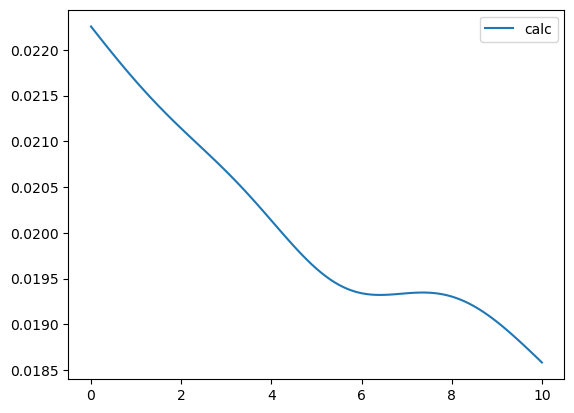

In [145]:
i = 2
states, H = read_data("data.hdf5", 2, "train", i, i+1)
H0 = H[0,0]
psi0 = states[0,0]

model.eval()

# Disable gradient computation and reduce memory consumption.
state_list = [psi0]
with torch.no_grad():
    for i in range(H.shape[1]-1):
        input_tensor = torch.tensor(np.concatenate((state_list[-1].flatten(), H[0,i].flatten())), dtype=torch.complex128).to(device)
        print(input_tensor)
        output_tensor = model(input_tensor).cpu()
        print(output_tensor)
        state_list.append(np.array(output_tensor))


prob0 = np.abs(states[0,:,0])**2
t_end=10
dt = 0.1
t_list = np.arange(0, t_end+dt, dt)
states_calc = [qt.Qobj(x) for x in state_list]
prob0_calc = [np.abs(s[0][0][0])**2 for s in states_calc]
# plt.plot(t_list, prob0, label="saved")
plt.plot(t_list, prob0_calc, label="calc")
plt.legend()